In [159]:
import io
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid 
from torchvision.models import resnet50, ResNet50_Weights
import lightning as L
import torch.nn.functional as F
from torchmetrics.classification import BinaryF1Score, BinaryConfusionMatrix, BinaryAccuracy, BinaryRecall, BinaryPrecision
from torchmetrics import MetricCollection
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
import PIL.Image
from torchvision.transforms import ToTensor, InterpolationMode
import numpy as np
import seaborn as sns

## Hyperparameters

In [160]:
BATCH_SIZE = 32
NUM_WORKERS = 7 # 7 because that what it suggested in a warning message
PERSISTENT_WORKERS = True # Suggested to do this in a warning message for faster init

USE_AUGMENT = True
CUSTOM_TRAIN_VAL_SPLIT = True
TRAIN_FRACTION = 0.8
VALIDATION_FRACTION = 1 - TRAIN_FRACTION

LEARNING_RATE = 1e-3
EPOCHS = 100

## Load data

In [161]:
CLASS_LABELS = ["Normal", "Pneumonia"]
DATA_DIR = "chest_xray" # Change this to chest_xray folder
data_dir_train = DATA_DIR + "/train"
data_dir_val = DATA_DIR + "/val"
data_dir_test = DATA_DIR + "/test"

# Some desired transforms for ResNet50
# https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50
transform = transforms.Compose(
    [
        transforms.Resize(size=(256, 256)),
        transforms.CenterCrop(size=(224, 224)),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # 
    ]
)
# The Effectiveness of Image Augmentation in Deep Learning Networks for Detecting COVID-19: A Geometric Transformation Perspective
# https://www.frontiersin.org/articles/10.3389/fmed.2021.629134/full
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10, interpolation=InterpolationMode.NEAREST_EXACT),
#    transforms.RandomResizedCrop(size=(256, 256), scale=(0.1, 0.9), ratio=(1, 1)),
    transform,
]) if USE_AUGMENT else transform

dataset_train = datasets.ImageFolder(data_dir_train, train_transform)
dataset_val = datasets.ImageFolder(data_dir_val, transform)

if CUSTOM_TRAIN_VAL_SPLIT:
    generator1 = torch. Generator().manual_seed(42)
    dataset = torch.utils.data.ConcatDataset([dataset_train, dataset_val])
    dataset_train, dataset_val = torch.utils.data.random_split(dataset,
                                                               [TRAIN_FRACTION, VALIDATION_FRACTION],
                                                               generator=generator1)
    dataset_train.transform = train_transform
    dataset_val.transform = transform

dataset_test = datasets.ImageFolder(data_dir_test, transform)

train_loader = DataLoader(
    dataset_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS, 
    persistent_workers= PERSISTENT_WORKERS
)
val_loader = DataLoader(
    dataset_val, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    persistent_workers= PERSISTENT_WORKERS
)
test_loader = DataLoader(
    dataset_test, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    persistent_workers= PERSISTENT_WORKERS
)

## Plot some example images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[1, 1, 0],
        [0, 1, 0],
        [1, 1, 1]])


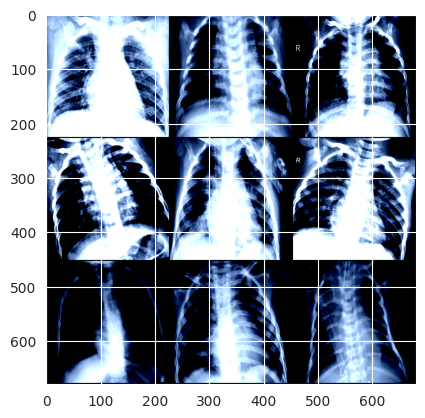

In [162]:
examples = next(iter(train_loader))
images, labels = examples
grid = make_grid(images[:9], nrow=3)
plt.imshow(grid.permute(1, 2, 0))
print(labels[:9].reshape(3,3))

## Load ResNet50 model

In [163]:
#Load best resNet50 weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)

#Change output layer to 2 classes
model.fc = torch.nn.Linear(
    in_features=2048,
    out_features=2,
    bias=True
)

#Freeze all layers except fc
for name, param in model.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

## Create Lightning module

In [164]:
class Classificator(L.LightningModule):
    def __init__(self, rn50, class_labels):
        super().__init__()
        self.rn50 = rn50
        self.class_labels = class_labels
        self.train_confusion_matrix = BinaryConfusionMatrix()
        self.val_confusion_matrix = BinaryConfusionMatrix()
        self.test_confusion_matrix = BinaryConfusionMatrix()
        metrics = MetricCollection([
            BinaryPrecision(),
            BinaryRecall(),
            BinaryF1Score(),
            BinaryAccuracy()
        ])
        self.train_metrics = metrics.clone(prefix='train_')
        self.valid_metrics = metrics.clone(prefix='val_')
        self.test_metrics = metrics.clone(prefix="test_")


    def training_step(self, batch):
        images, labels = batch
        output = self.rn50(images)
        _, preds = torch.max(output, dim=1)
        loss = F.cross_entropy(output, labels)
        self.log("Traning loss", loss, prog_bar=True)
        out_metric = self.train_metrics(preds, labels)
        self.log_dict(out_metric)
        self.train_confusion_matrix.update(preds, labels)
        return loss
    
    def on_train_epoch_end(self):
        cm = self.train_confusion_matrix.compute()
        image = self.transform_confusion_matrix(cm)
        self.logger.experiment.add_image("Confusion matrix train results", image)
        self.train_confusion_matrix.reset() 

    def validation_step(self, batch):
        images, labels = batch
        output = self.rn50(images)
        loss = F.cross_entropy(output, labels)
        _, preds = torch.max(output, dim=1)
        self.val_confusion_matrix.update(preds, labels)
        self.log("Validation loss", loss, prog_bar=True)
        self.valid_metrics.update(preds, labels)
        return loss
    
    def on_validation_epoch_end(self):
        output = self.valid_metrics.compute()
        self.log_dict(output)
        self.valid_metrics.reset()
        cm = self.val_confusion_matrix.compute()
        image = self.transform_confusion_matrix(cm)
        self.logger.experiment.add_image("Confusion matrix validation results", image)
        self.val_confusion_matrix.reset()
    
    def test_step(self, batch):
        images, labels = batch
        output = self.rn50(images)
        loss = F.cross_entropy(output, labels)
        _, preds = torch.max(output, dim=1)
        self.test_metrics.update(preds, labels)
        self.test_confusion_matrix.update(preds, labels)
        self.log("Test loss", loss, prog_bar=True)
        self.log_dict(self.test_metrics.compute())

    def on_test_end(self):
        cm = self.test_confusion_matrix.compute()
        image = self.transform_confusion_matrix(cm)
        self.logger.experiment.add_image("Confusion matrix test results", image)

    # Takes a tensor and plot confusion matrix from it and then return as tensor
    def transform_confusion_matrix(self, cm):
        cm = cm.cpu().numpy()
        fig = plt.figure()
        sns.heatmap(cm, annot=True, xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS, fmt="g", cbar=False)
        buf = io.BytesIO()
        fig.savefig(buf, format='png')
        buf.seek(0)
        image = PIL.Image.open(buf)
        image = ToTensor()(image)
        plt.close()
        return image


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE)
        return optimizer

## Run training and validation loops

In [165]:
classifier = Classificator(model, CLASS_LABELS)
early_stop_callback = EarlyStopping(monitor="Validation loss", min_delta=1e-6, patience=10)
checkpoint = L.pytorch.callbacks.ModelCheckpoint(dirpath="pneumonia_model/ResNet/")
callbacks = [early_stop_callback, checkpoint]
logger = TensorBoardLogger("lightning_logs",
                           name=f"resnet/{'augment' if USE_AUGMENT else 'original'}",
                           )

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    logger=logger,
    max_epochs=EPOCHS,
    reload_dataloaders_every_n_epochs=3,
    callbacks=callbacks
)
trainer.fit(
    model = classifier,
    train_dataloaders = train_loader, 
    val_dataloaders = val_loader
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/roger/.local/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/roger/jupyter_data/gits/D7047E-Project/pneumonia_model/ResNet exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                  | Params | Mode 
-------------------------------------------------------------------------
0 | rn50                   | ResNet                | 23.5 M | train
1 | train_confusion_matrix | BinaryConfusionMatrix | 0      | train
2 | val_confusion_matrix   | BinaryConfusionMatrix | 0      | train
3 | test_confusion_matrix  | BinaryConfusionMatrix | 0      | train
4 | train_metrics          | MetricCollection      | 0      | train
5 | valid_metrics          | MetricCollection      | 0      | train
6 | test_metrics           | MetricCollection      | 0      | train
--------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Test model
Only implemented and tested but should not use until final model is decided

In [166]:
#trainer.test(model = classifier, dataloaders=test_loader)

In [167]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/